# Tutorial 3 - How to use ordinal preferences instead of cardinal

In this notebook, we are going to see how to implement an election with **ordinal preferences** in our model of voters with embeddings.

An election with **ordinal preferences** corresponds to an election in which each voter gives a **ranking** of the candidates instead of giving a different **score** to each candidate. It has been studied a lot and many rules exists for this model (*Plurality, Borda, k-approval, Condorcet, Instand Runoff, Maximin, etc.*).

In [1]:
import embedded_voting as ev
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(589866470)

## Classic election

Let's **run an election** with **5 candidates** and **100 voters**. We obtain the following profile:

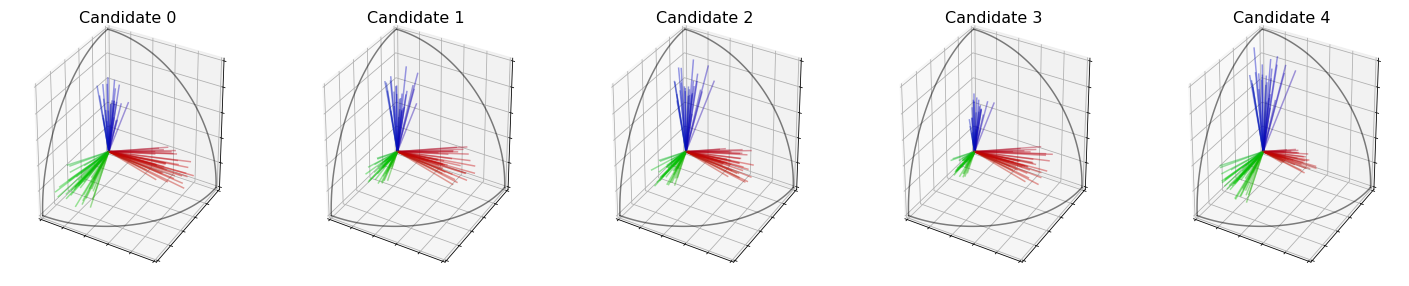

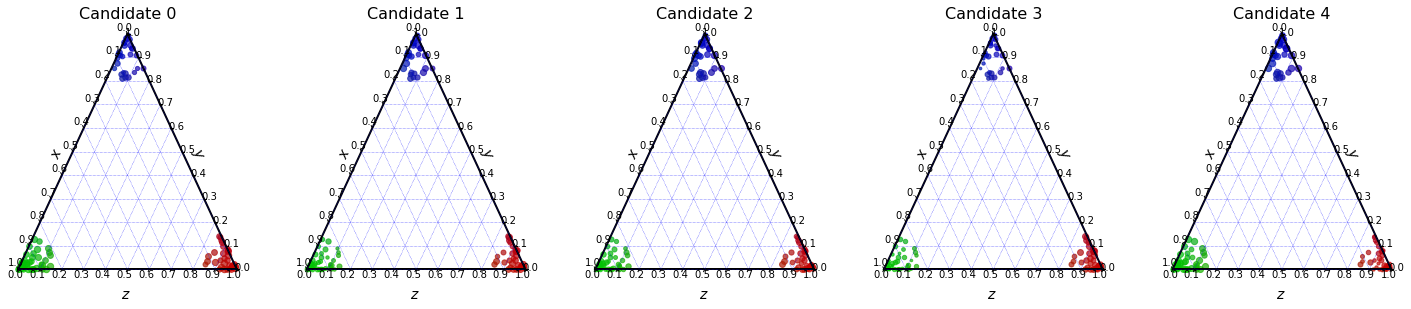

In [2]:
n_voters = 100
n_candidates = 5
n_dimensions = 3

generator = ev.ProfileGenerator(n_voters, n_candidates, n_dimensions)

embeddingsGen = ev.ParametrizedEmbeddings(n_voters, n_dimensions)
ratingsGen = ev.CorrelatedRatings(n_candidates, n_dimensions)

embeddings = embeddingsGen(polarisation=0.5)
profile = ratingsGen(embeddings, coherence=0.6)

embeddings.plot_candidates(profile, "3D")
embeddings.plot_candidates(profile, "ternary")

If we use the rule **SVDNash**, we obtain the following ranking:

$$
c_0 > c_4 > c_2 > c_1 > c_3
$$



In [3]:
election = ev.SVDNash()
election(profile, embeddings)

We can also print **all the information** about the results of this rule:

In [4]:
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)

Scores :  [77.4529444052501, 56.38044483063454, 61.983702426260045, 39.689114840965, 65.12524089703435]
Ranking :  [0, 4, 2, 1, 3]
Winner :  0
Welfare :  [1.0, 0.4419925145900791, 0.5903688222970906, 0.0, 0.673557908441717]


## Positional scoring rules

Now, let's assume that instead of asking a **score vector** to each voter, we ask for a **ranking** of the candidate, and apply some rule with all the rankings.

A broad family of rule are **positional scoring rule**. A positional scoring rule is characterized by a vector $p = (p_1, \ldots, p_m)$ such that each voter $v_i$ gives $p_j$ points to the voters with rank $j$. The winner is the candidate with the maximum total score.

We can adapt this idea to scores between $0$ and $1$ by setting the score given by the voter $v_i$ to candidate $c_j$ as $\frac{p_k}{p_n}$ if the candidate $c_j$ is ranked at position $k$ in the ranking of $v_i$.

For instance, if the positional scoring rule is $(2, 1, 1, 1, 0)$, each voter gives a score of $1$ to her favorite candidate, $0$ to her least favorite candidate and $\frac{1}{2}$ to every other candidate:

In [5]:
ordinal_election = ev.PositionalRuleExtension([2, 1, 1, 1, 0], rule=ev.SVDNash())
ordinal_election(profile, embeddings)

If we plot the profile of the candidates now, it is very different than before:

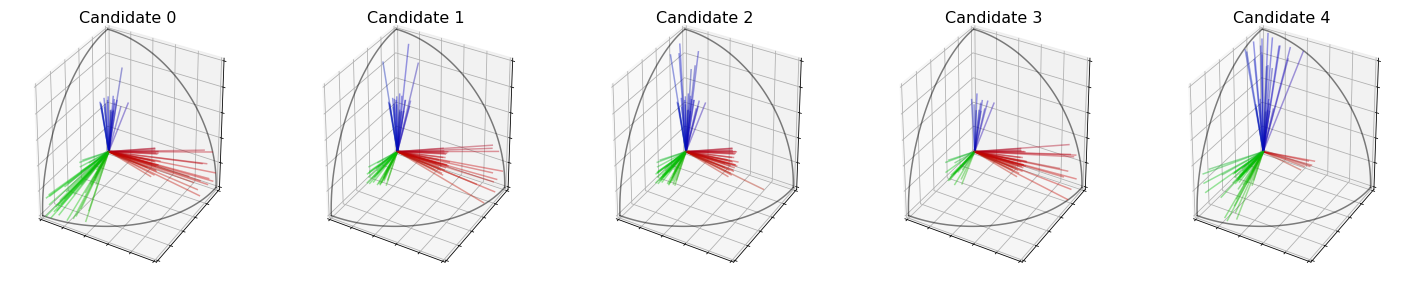

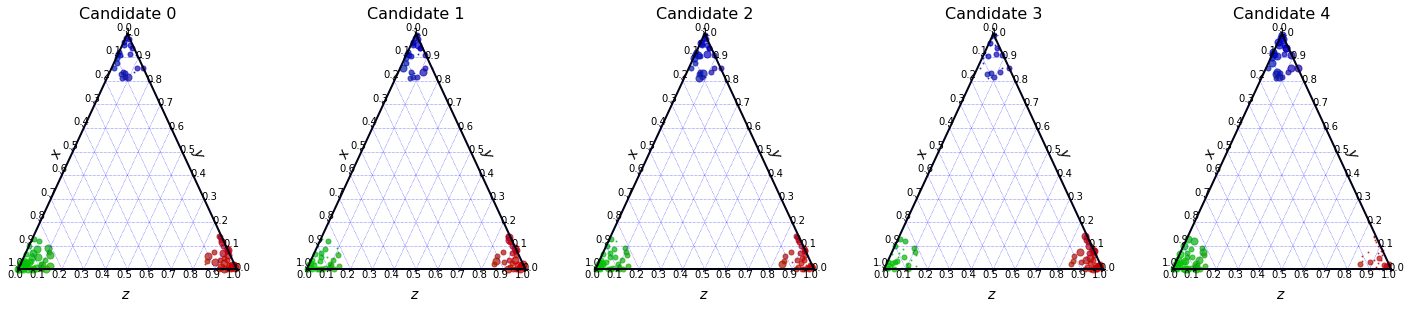

In [6]:
ordinal_election.plot_fake_profile("3D")
ordinal_election.plot_fake_profile("ternary")

The ranking obtained is different too. Indeed, the new ranking is 

$$
c_0 > c_2 > c_1 > c_4 > c_3
$$


In [7]:
print('Scores : ', ordinal_election.scores_)
print('Ranking : ', ordinal_election.ranking_)
print('Winner : ', ordinal_election.winner_)

Scores :  [75.63780222990167, 51.43735532699569, 54.420067571219825, 25.800077340686165, 37.34611531212104]
Ranking :  [0, 2, 1, 4, 3]
Winner :  0


### Plurality

**Plurality** is the positional scoring rule defined by the scoring vector $(1, 0, \ldots, 0)$. It is equivalent to saying that each voter only vote for his favorite candidate. We can see that in that case, almost nobody voted for candidate $c_4$:

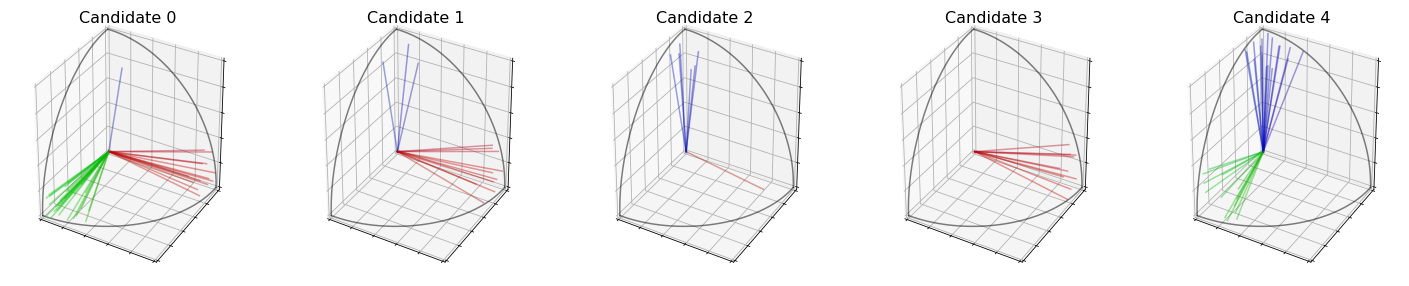

In [8]:
plurality_election = ev.PluralityExtension(n_candidates, rule=ev.SVDNash())
plurality_election(profile, embeddings)
plurality_election.plot_fake_profile("3D")

The ranking obtained is different again :

$$
c_0 > c_4 > c_1 > c_2 > c_3
$$



In [9]:
print('Scores : ', plurality_election.scores_)
print('Ranking : ', plurality_election.ranking_)
print('Winner : ', plurality_election.winner_)

Scores :  [16.601716427728196, 1.9081883124081562, 0.34458913321859747, 0.22990664590446067, 8.548226426205636]
Ranking :  [0, 4, 1, 2, 3]
Winner :  0


### Veto

The **Veto** is the opposite of Plurality. In this rule, every voter votes for all candidates **but one**. That is why it looks like every candidate is liked by a lot of voters:

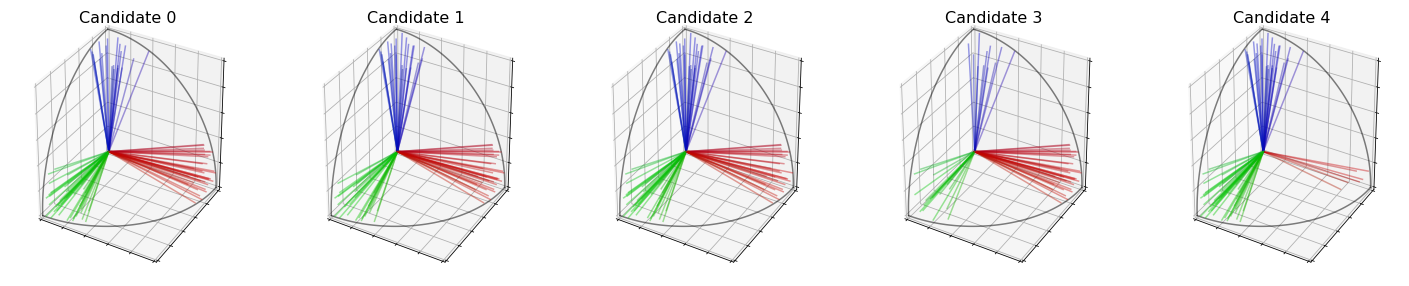

In [10]:
veto_election = ev.VetoExtension(n_candidates, rule=ev.SVDNash())
veto_election(profile, embeddings)
veto_election.plot_fake_profile("3D")

The ranking is different again, and the new winner is $c_2$:

$$
c_2 > c_0 > c_1 > c_4 > c_3
$$



In [11]:
print('Scores : ', veto_election.scores_)
print('Ranking : ', veto_election.ranking_)
print('Winner : ', veto_election.winner_)

Scores :  [136.02900901695878, 119.78701362584845, 137.28853253221763, 63.667358756835526, 69.2289388293391]
Ranking :  [2, 0, 1, 4, 3]
Winner :  2


### k-Approval

**K-approval** is the rule in between Plurality and Veto. Each voter votes for his **k** favorite candidates only. For instance, with $k=3$ :

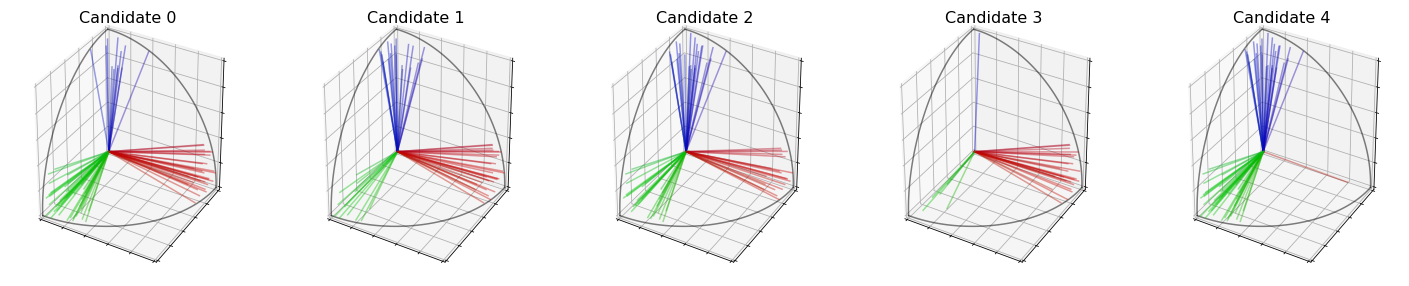

In [12]:
kapp_election = ev.KApprovalExtension(n_candidates, k=3, rule=ev.SVDNash())
kapp_election(profile, embeddings)
kapp_election.plot_fake_profile("3D")

The ranking is different again:

$$
c_0 > c_2>  c_1 > c_4 > c_3
$$


In [13]:
print('Scores : ', kapp_election.scores_)
print('Ranking : ', kapp_election.ranking_)
print('Winner : ', kapp_election.winner_)

Scores :  [96.85905561318343, 66.8349761272407, 87.93273683090769, 11.472171941569107, 33.77548291803446]
Ranking :  [0, 2, 1, 4, 3]
Winner :  0


### Borda

**Borda** use the scoring vector $(m-1, m-2, \ldots, 1, 0)$ where $m$ is the total number of candidates.

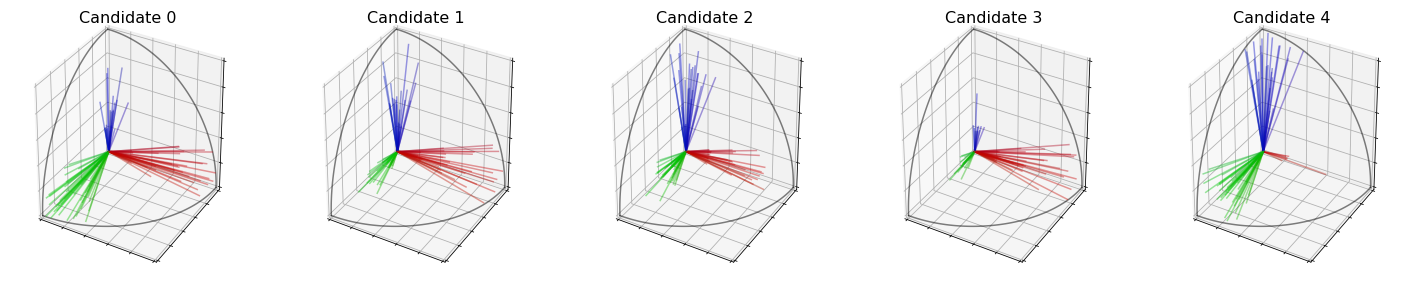

In [14]:
borda_election = ev.BordaExtension(n_candidates, rule=ev.SVDNash())
borda_election(profile, embeddings)
borda_election.plot_fake_profile("3D")

With this rule, we obtain **the same ranking** than previously:
$$
c_0 > c_2 > c_1 > c_4 >c_3
$$

In [15]:
print('Scores : ', borda_election.scores_)
print('Ranking : ', borda_election.ranking_)
print('Winner : ', borda_election.winner_)

Scores :  [75.96437844397376, 45.86050902355657, 55.505989141120835, 15.584561665067797, 36.16340821827398]
Ranking :  [0, 2, 1, 4, 3]
Winner :  0


## Instant Runoff Voting (IRV)

Finally, we implemented **Instant Runoff Voting** which is not a positional scoring rule.

In this voting system, at each step, every voter votes for his favorite candidate, and the candidate with the lowest score **is eliminated**. Consequently, we perform $m-1$ elections before we can find the winner. The ranking obtained is the inverse of the order in which the candidates are eliminated.

In [16]:
irv_election = ev.InstantRunoffExtension(rule=ev.SVDNash())
irv_election(profile, embeddings)

In our case, we obtain the following ranking
$$
c_0 > c_4> c_1 > c_2 > c_3
$$

In [17]:
print('Ranking : ', irv_election.ranking_)
print('Winner : ', irv_election.winner_)

Ranking :  [0, 4, 1, 2, 3]
Winner :  0
